In [6]:
import glob
import os
import random
import zipfile
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
info = pd.read_excel("data/RNAseq.xls")
info = info[~info["Replicate"].isna()]
samples = list(info["Sample"])

# Report Base quality and GC content

In [7]:
array = []
for path in sorted(glob.glob("results/prepare/fastqc/*_fastqc.zip")):
    sample = path.split("/")[-1].strip("_fastqc.zip")[:-3]  # _R1 or _R2
    if sample not in samples:
        continue
    with zipfile.ZipFile(path, "r") as f:
        for name in f.namelist():
            if not name.endswith("/fastqc_data.txt"):
                continue
            with f.open(name) as h:
                lines = []
                for line in h:
                    line = line.decode("utf-8")
                    lines.append(line.strip("\n"))

                d1 = dict()
                for i, line in enumerate(lines):
                    if line.startswith(">>Per sequence quality scores"):
                        j = i + 2
                        while j < len(lines):
                            line1 = lines[j]
                            if line1 == ">>END_MODULE":
                                break
                            qua, count = line1.split("\t")
                            d1[int(qua)] = float(count)
                            j += 1
                        break

                d2 = dict()
                for i, line in enumerate(lines):
                    if line.startswith(">>Per sequence GC content"):
                        j = i + 2
                        while j < len(lines):
                            line1 = lines[j]
                            if line1 == ">>END_MODULE":
                                break
                            gc, count = line1.split("\t")
                            d2[int(gc)] = float(count)
                            j += 1
                        break
                array.append([d1, d2])

In [8]:
total = 0
count = 0
for d1, d2 in array:
    for qua, c in d1.items():
        total += c
        if qua >= 30:
            count += c
ratio = count / total
print("Total reads: ", total)
print("Reads with average base quality >= 30:", ratio)

Total reads:  6850935558.0
Reads with average base quality >= 30: 0.9726263684116819


In [9]:
d = defaultdict(int)
for d1, d2 in array:
    for qua, c in d1.items():
        d[qua] += c
xs = []
ys = []
for x in sorted(d.keys()):
    xs.append(x)
    ys.append(d[x])
ys = np.array(ys)
ys = ys * 100 / sum(ys)

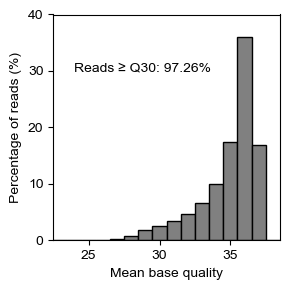

In [10]:
plt.figure(figsize=(3, 3))
plt.bar(xs, ys, color="grey", edgecolor="black", lw=1, width=1)
plt.text(24, 30, "Reads ≥ Q30: %.2f%%" % (ratio * 100))
plt.xlabel("Mean base quality")
plt.ylabel("Percentage of reads (%)")
plt.yticks([0, 10, 20, 30, 40])
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 40)
plt.tight_layout()
plt.savefig("figures/Mean_base_quality.bar.pdf", dpi=300)

In [11]:
xs = np.arange(0, 101)
ys = np.zeros(101)
for d1, d2 in array:
    for k, v in d2.items():
        ys[k] += v

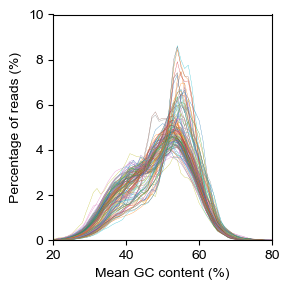

In [12]:
plt.figure(figsize=(3, 3))
for d1, d2 in array:
    xs = np.arange(0, 101)
    ys = np.zeros(101)
    for k, v in d2.items():
        ys[k] += v
    ys = ys * 100 / sum(ys)
    plt.plot(xs, ys, lw=0.2)
plt.xlabel("Mean GC content (%)")
plt.ylabel("Percentage of reads (%)")
plt.xlim(20, 80)
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

# Read number of different batch

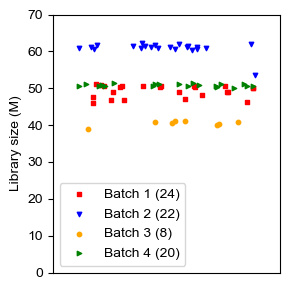

In [13]:
np.random.seed(0)

dat = pd.read_csv("reports/star_mapped_logs.tsv", sep="\t", index_col=0)

ys = dat["Number of input reads"].values / 1e6
xs = np.random.rand(len(ys)) * 0.8 + 0.1

batches = []
for sample in dat.index:
    path1 = "data/datasets/%s_R1.fastq.gz" % sample
    path2 = os.readlink(path1)
    if "F20FTSCCKF0955_FISgaaE" in path2:
        batches.append(0)
    elif "F20FTSCCKF1558_YUocvE" in path2:
        batches.append(1)
    elif "F21FTSCCKF2946_SERvuzhR" in path2:
        batches.append(2)
    else:
        batches.append(3)

xs1 = []
ys1 = []
xs2 = []
ys2 = []
xs3 = []
ys3 = []
xs4 = []
ys4 = []
for x, y, b in zip(xs, ys, batches):
    if b == 0:
        xs1.append(x)
        ys1.append(y)
    elif b == 1:
        xs2.append(x)
        ys2.append(y)
    elif b == 2:
        xs3.append(x)
        ys3.append(y)
    else:
        xs4.append(x)
        ys4.append(y)
        
plt.figure(figsize=(3, 3))
plt.scatter(xs1, ys1, color="red", marker="s", s=10, label="Batch 1 (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker="v", s=10, label="Batch 2 (%d)" % len(xs2))
plt.scatter(xs3, ys3, color="orange", marker="o", s=10, label="Batch 3 (%d)" % len(xs3))
plt.scatter(xs4, ys4, color="green", marker=">", s=10, label="Batch 4 (%d)" % len(xs4))

plt.xlim(0, 1)
plt.xticks([])
plt.ylim(0, 70)
plt.yticks(np.arange(0, 80, 10))
plt.ylabel("Library size (M)")
plt.legend(frameon=True)

plt.tight_layout()
plt.show()

# Correlation of expression

In [16]:
array = []
for path in sorted(glob.glob("results/expression/stringtie/*/gene_abund.tab")):
    sample = path.split("/")[-2]
    d = pd.read_csv(path, sep="\t", header=0, index_col=0)
    d = d[~d.index.duplicated()]
    s = d["FPKM"]
    s.name = sample
    array.append(s)
mtx = pd.concat(array, axis=1)
mtx.index.name = "Gene"
mtx.to_csv("reports/fpkm_known_genes.tsv", sep="\t")

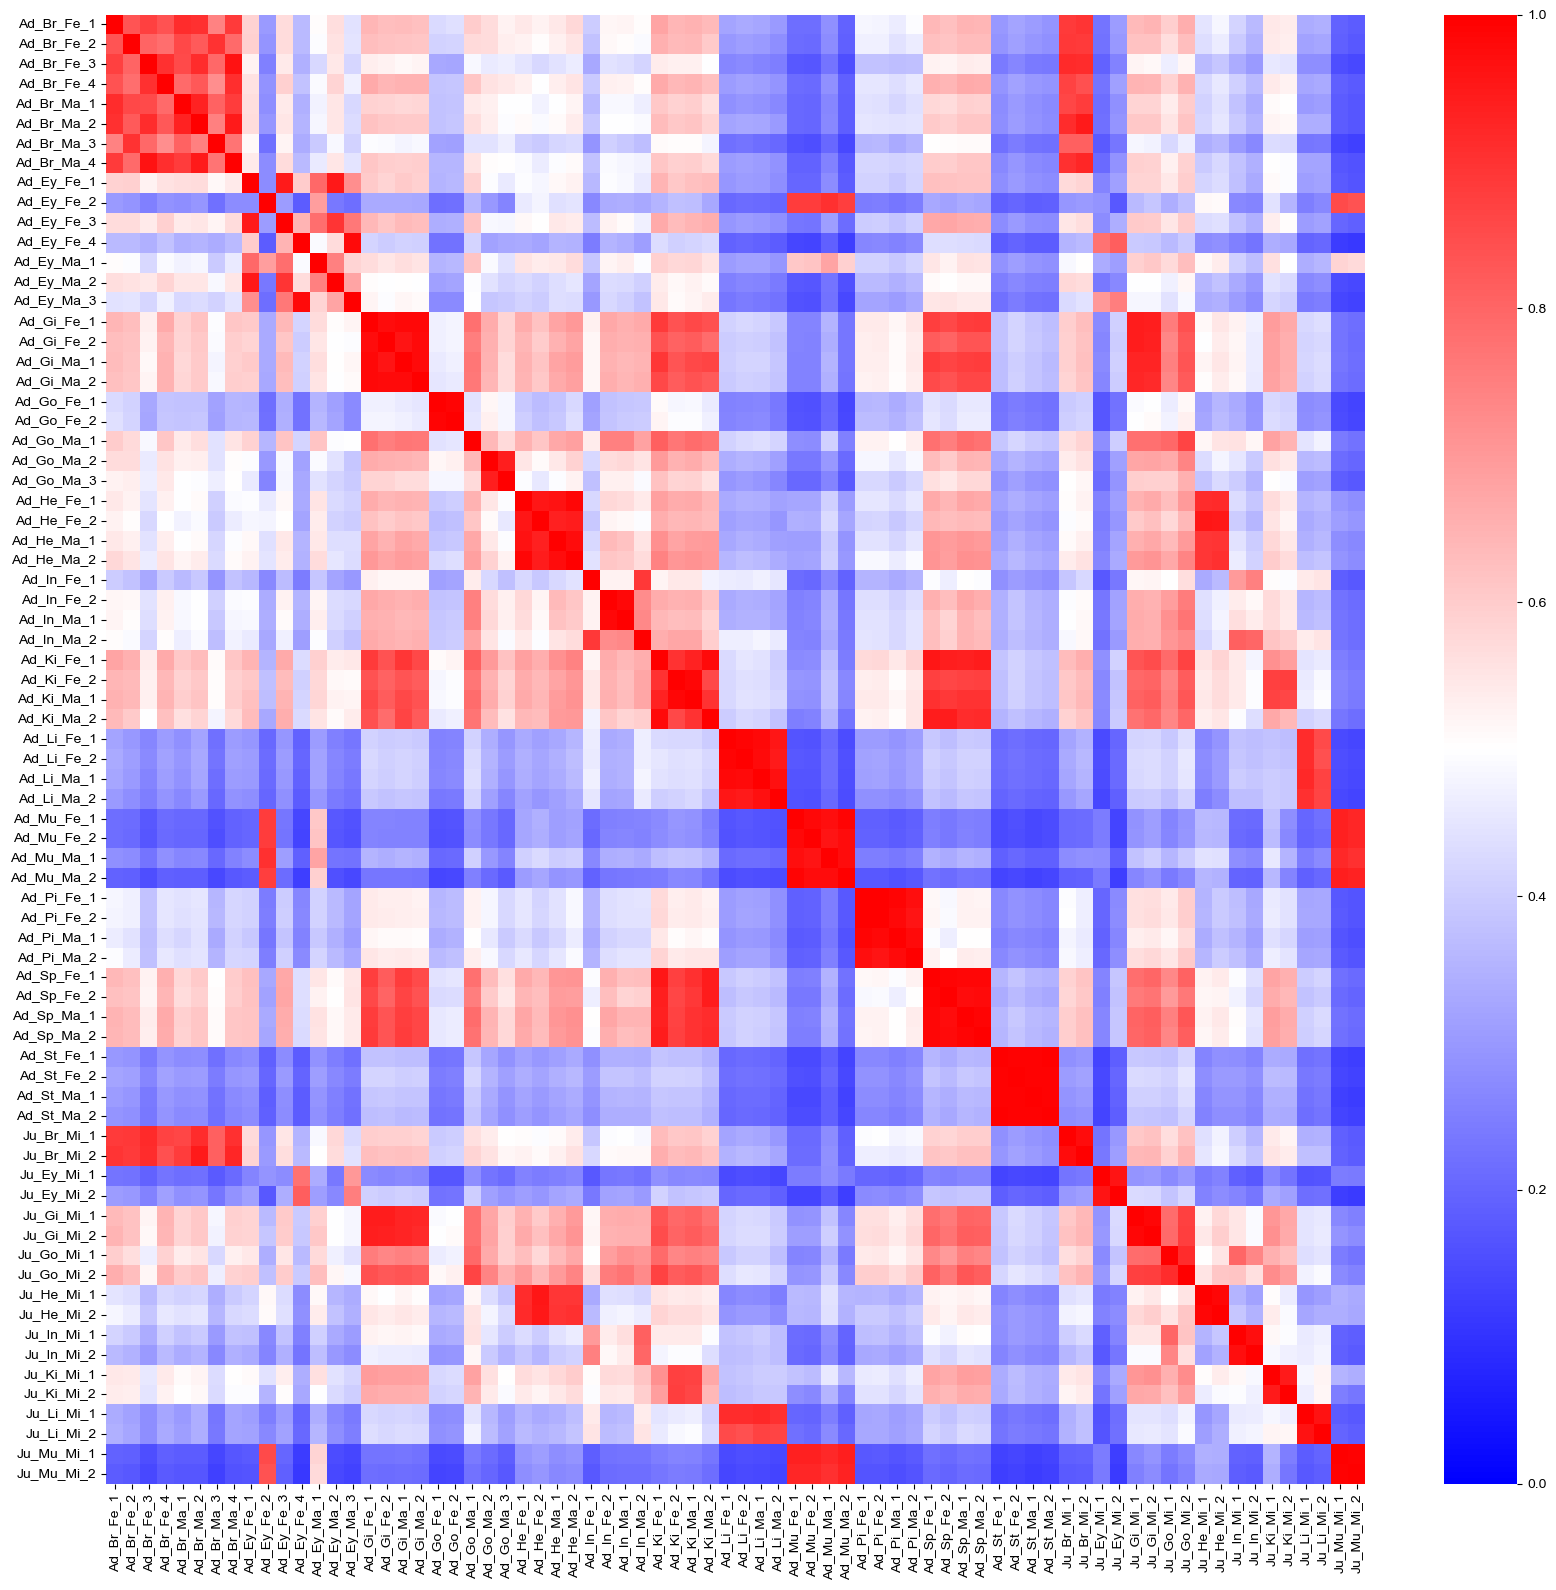

In [18]:
mtx = pd.read_csv("reports/fpkm_known_genes.tsv", sep="\t", index_col=0)
corr = mtx.corr()
plt.figure(figsize=(17, 16))
sns.heatmap(corr, cmap="bwr", vmin=0, vmax=1)
plt.tight_layout()
plt.savefig("figures/expression_correlation.heatmap.pdf", dpi=300)

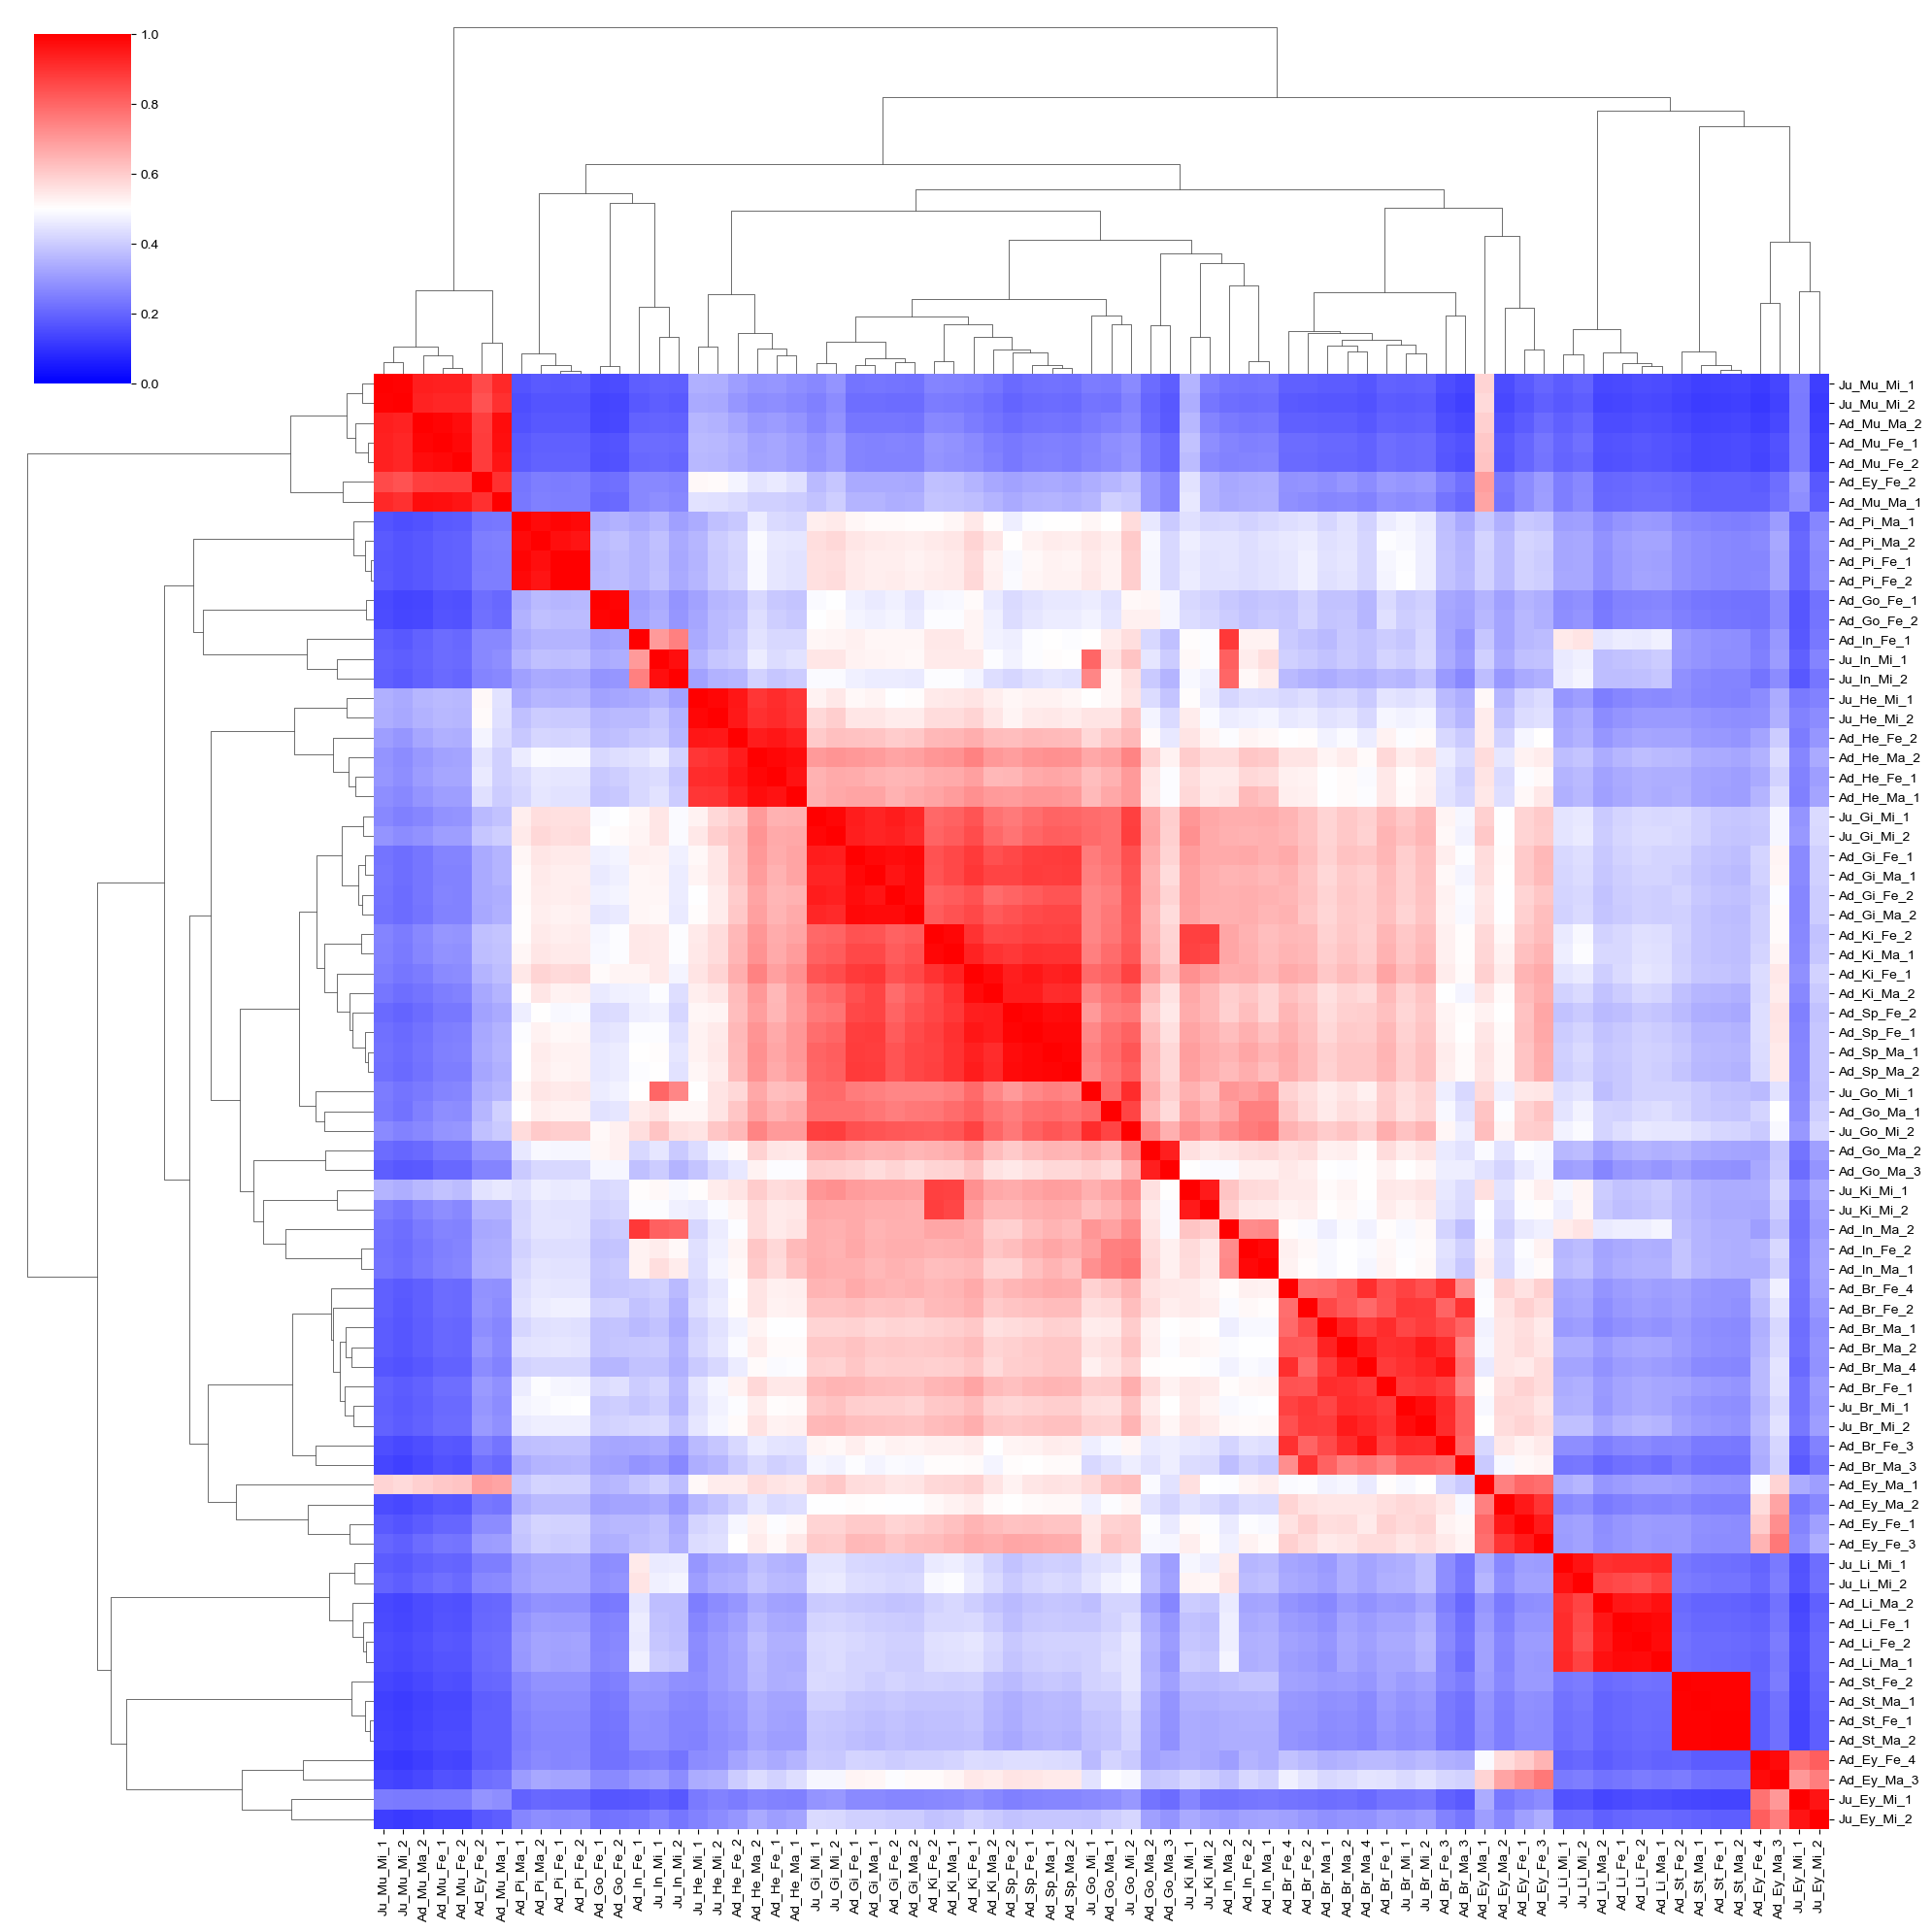

In [19]:
ret = sns.clustermap(corr, cmap="bwr", vmin=0, vmax=1, figsize=(20, 20))
ret.fig.savefig("figures/expression_correlation.clustermap.pdf", dpi=300)

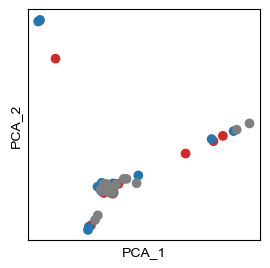

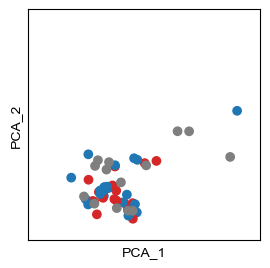

In [21]:
pca = PCA(n_components=2)
ret = pca.fit_transform(mtx.T)
m = pd.DataFrame(ret, index=pd.Index(mtx.columns, name="Sample"), columns=["X", "Y"])
xs = m["X"]
ys = m["Y"]
colors = []
for s in m.index:
    if "Ma" in s:
        colors.append("C0")
    elif "Fe" in s:
        colors.append("C3")
    else:
        colors.append("C7")

plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, color=colors)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, color=colors)
plt.xticks([])
plt.yticks([])
plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.xlim(-5000, 5000)
plt.ylim(-3000, 3000)
plt.show()

# Report summary

## Merge STAR log of all samples


In [24]:
def get_star_logs(prefix):
    array = []
    for path in sorted(glob.glob(prefix + "/*/Log.final.out")):
        names = []
        values = []
        with open(path) as f:
            for line in f:
                if "|" not in line:
                    continue
                name, value = line.strip("\n").split("|")
                names.append(name.strip())
                values.append(value.strip())
        s = pd.Series(values, index=names, name=path.split("/")[-2])
        array.append(s)
    dat = pd.DataFrame(array)
    dat.index.name = "Sample"
    return dat

dat = get_star_logs("results/mapping/star/mapped")
dat.to_csv("reports/star_mapped_logs.tsv", sep="\t")

dat = get_star_logs("results/denovo_mapping/star/mapped.1st")
dat.to_csv("reports/star_mapped_logs.1st.tsv", sep="\t")

dat = get_star_logs("results/denovo_mapping/star/mapped.2nd")
dat.to_csv("reports/star_mapped_logs.2nd.tsv", sep="\t")

## Summary of read numbers

In [25]:
dat = pd.read_csv("reports/star_mapped_logs.2nd.tsv", sep="\t", index_col=0)
total = np.sum(dat["Number of input reads"])
mean = np.mean(dat["Number of input reads"])
std = np.std(dat["Number of input reads"])
print("Total: %s" % format(total, ","))
print("Mean: %s" % format(round(mean, 2), ","))
print("Std: %s" % format(round(std, 2), ","))

Total: 3,425,467,779
Mean: 51,901,026.95
Std: 6,336,743.14


## Summary of mapped ratio

Mean:	90.37939393939394	7.429090909090907	1.7907575757575758	0.4022727272727273
Std:	2.4439374779790084	2.378314029386704	0.5446757980135751	0.7203050538691025


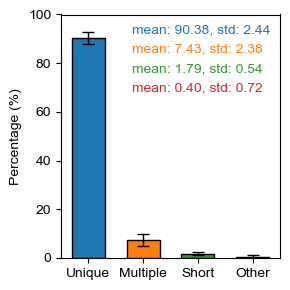

In [26]:
dat = pd.read_csv("reports/star_mapped_logs.2nd.tsv", sep="\t", index_col=0)
rows = []
for vs in dat[["Uniquely mapped reads %", 
               "% of reads mapped to multiple loci",
               "% of reads mapped to too many loci", 
               "% of reads unmapped: too short", 
               "% of reads unmapped: other"]].values:
    vs = [float(v[:-1]) for v in vs]
    vs = [vs[0], vs[1] + vs[2], vs[3], vs[4]]
    rows.append(vs)
d = pd.DataFrame(rows)
ys = d.mean()
ye = d.std()
print("Mean:", *ys.values, sep="\t")
print("Std:", *ye.values, sep="\t")
xs = [0, 1, 2, 3]
xticks = ["Unique", "Multiple", "Short", "Other"]
colors = ["C0", "C1", "C2", "C3"]
plt.figure(figsize=(3, 3))
plt.bar(xs, ys, yerr=ye, width=0.6, 
        color=colors, lw=1, 
        edgecolor="black", 
        error_kw={"capsize": 4, "linewidth": 1, "capthick": 1})
for i, (mean, std, c) in enumerate(zip(ys, ye, colors)):
    plt.text(0.8, 100 - (i+1) * 8, "mean: %.2f, std: %.2f" % (mean, std), color=c)
plt.xlim(-0.5, 3.5)
plt.xticks(xs, xticks, rotation=0)
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.tight_layout()
plt.savefig("figures/mapping.ratio.bar.pdf", dpi=300)

## Unique and multi mapped ratio (scatter)

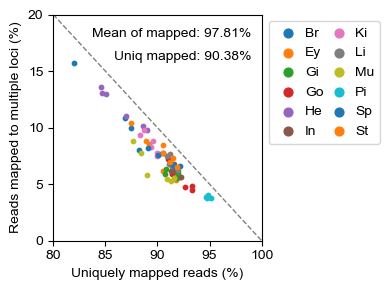

In [27]:
dat = pd.read_csv("reports/star_mapped_logs.2nd.tsv", sep="\t", index_col=0)

xs = [float(v[:-1]) for v in dat["Uniquely mapped reads %"]]
ys1 = [float(v[:-1]) for v in dat["% of reads mapped to too many loci"]]
ys2 = [float(v[:-1]) for v in dat["% of reads mapped to multiple loci"]]
ys = np.array(ys1) + np.array(ys2)

zs = np.array(xs) + np.array(ys)
m = np.mean(zs)
mx = np.mean(xs)

tissues = list(sorted(set([v.split("_")[1] for v in dat.index])))
plt.figure(figsize=(4, 3))
for i, t in enumerate(tissues):
    tmp = dat[[v.split("_")[1] == t for v in dat.index]]
    xs = [float(v[:-1]) for v in tmp["Uniquely mapped reads %"]]
    ys1 = [float(v[:-1]) for v in tmp["% of reads mapped to too many loci"]]
    ys2 = [float(v[:-1]) for v in tmp["% of reads mapped to multiple loci"]]
    ys = np.array(ys1) + np.array(ys2)
    plt.scatter(xs, ys, s=10, color="C%d" % i, label=t)
plt.plot([80, 100], [20, 0], lw=1, color="grey", ls="--")
plt.xlim(80, 100)
plt.ylim(0, 20)   
plt.text(99, 18, "Mean of mapped: %.2f%%" % m, ha="right")
plt.text(99, 16, "Uniq mapped: %.2f%%" % mx, ha="right")
plt.yticks(np.arange(0, 21, 5))
plt.xlabel("Uniquely mapped reads (%)")
plt.ylabel("Reads mapped to multiple loci (%)")
plt.legend(ncol=2, bbox_to_anchor=(1, 1), loc="upper left", markerscale=2, 
           columnspacing=0.1, handletextpad=0.2, frameon=True)
plt.tight_layout()
plt.savefig("figures/stat.star.mapped.2nd.pdf", dpi=300)

## Summary of sequencing and mapping (table)

In [28]:
dat = pd.read_csv("reports/star_mapped_logs.2nd.tsv", sep="\t", index_col=0)
tissues = sorted(set([n.split("_")[1] for n in dat.index]))
rows = []
for t in tissues:
    row = [t]
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ju_%s_Mi" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ad_%s_Fe" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ad_%s_Ma" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    rows.append(row)
d = pd.DataFrame(rows)
d.columns = ["Tissue", 
             "Ju_Mi_Rep1", "Ju_Mi_Rep1(%)", "Ju_Mi_Rep2", "Ju_Mi_Rep2(%)", 
             "Ad_Fe_Rep1", "Ad_Fe_Rep1(%)", "Ad_Fe_Rep2", "Ad_Fe_Rep2(%)",
             "Ad_Ma_Rep1", "Ad_Ma_Rep1(%)", "Ad_Ma_Rep2", "Ad_Ma_Rep2(%)"]
d.to_csv("reports/mapped.2nd.table.tsv", sep="\t", index=False)

## Report MarkDuplicates log

In [29]:
array = []
for path in sorted(glob.glob("results/denovo_mapping/rmdup/*_metrics.txt")):
    sample = path.split("/")[-1][:-len("_metrics.txt")]
    with open(path) as f:
        lines = f.readlines()
        s = None
        for i, line in enumerate(lines):
            if line.startswith("## METRICS"):
                names = lines[i + 1].strip("\n").split("\t")
                values = lines[i + 2].strip("\n").split("\t")
                s = pd.Series(values, index=names)
                s.name = sample
                array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("reports/markdup_all_metrics.tsv", sep="\t")

## Plot MarkDuplicates summary

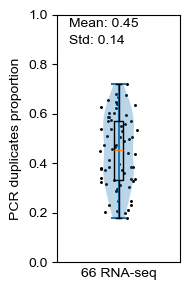

In [30]:
dat = pd.read_csv("reports/markdup_all_metrics.tsv", sep="\t", index_col=0)
values = dat["PERCENT_DUPLICATION"]

plt.figure(figsize=(2, 3))
random.seed(1)
xs = [0.7 + random.random() * 0.6  for i in range(len(values))]
plt.scatter(xs, values, marker=".", color="black", s=5)
plt.violinplot(values)
plt.boxplot(values)
plt.text(0.2, 0.95, "Mean: %.2f" % np.mean(values))
plt.text(0.2, 0.88, "Std: %.2f" % np.std(values))

plt.ylabel("PCR duplicates proportion")
plt.xlabel("66 RNA-seq")
plt.xticks([])
plt.ylim(0, 1)
plt.xlim(0, 2)
plt.tight_layout()
plt.savefig("figures/markdup.summary.pdf", dpi=300)